In [5]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0975564907207627, tolerance: 2.3708384755431475
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8979252297258427, tolerance: 2.3708384755431475
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.685459062860332, tolerance: 2.3708384755431475
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Convergen

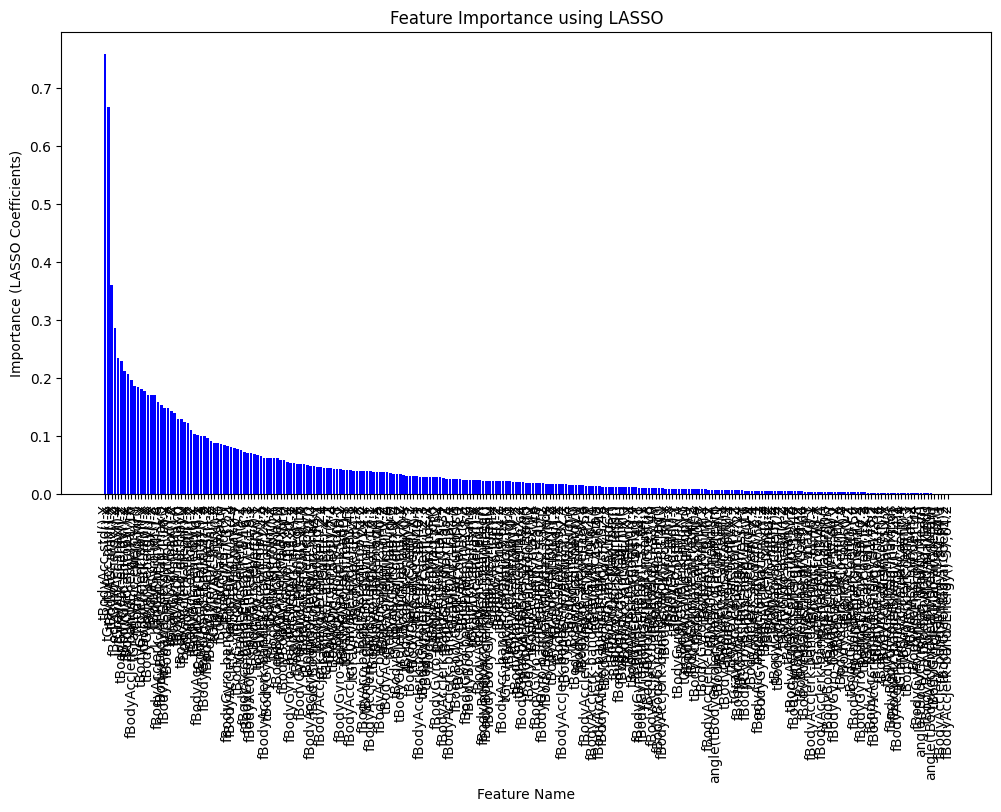

Running Cross-Validation: 100%|██████████| 2/2 [01:10<00:00, 35.24s/split]


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Model Test Accuracy: 0.9777
Precision: 0.9783
Recall (Sensitivity): 0.9777
Specificity: 0.9780
F1-Score: 0.9777
ROC AUC: 0.9993
Training Time (Best Model): 32.18 seconds
Inference Time: 1.85 seconds


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, ReLU, Flatten, Add, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_auc_score
)
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar
from scipy.stats.mstats import winsorize

# Load dataset
df = pd.read_csv('/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv')

# Encode target labels
label_encoder = LabelEncoder()
df['Activity'] = label_encoder.fit_transform(df['Activity'])

# Separate features and target
X = df.drop(columns=['Activity'])
y = df['Activity']

# === Outlier Detection & Replacement Using Winsorizing ===
winsor_limit = 0.1  # 10% Winsorizing (both sides)

for col in X.select_dtypes(include=[np.number]):  # Only numeric columns
    X[col] = winsorize(X[col], limits=[winsor_limit, winsor_limit])  # Apply Winsorizing

# Convert X back to a NumPy array after preprocessing
X = X.values

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Feature Selection using LASSO
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Extract absolute coefficients from the best alpha model
feature_importance = np.abs(lasso.coef_)

# Get feature names
feature_names = df.drop(columns=["Activity"]).columns

# Select non-zero features
selected_features = np.array(feature_names)[np.where(feature_importance > 0)[0]]

# Sort features by importance (descending order)
sorted_idx = np.argsort(feature_importance[np.where(feature_importance > 0)[0]])[::-1]

# Plot top selected features
plt.figure(figsize=(12, 6))
plt.bar(range(len(selected_features)), feature_importance[np.where(feature_importance > 0)][sorted_idx], align="center", color="blue")
plt.xticks(range(len(selected_features)), selected_features[sorted_idx], rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Importance (LASSO Coefficients)")
plt.title("Feature Importance using LASSO")
plt.show()

# Select features with non-zero coefficients
X_selected = X_scaled[:, np.where(feature_importance > 0)[0]]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Reshape for TCN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define TCN Residual Block with Dilated Convolutions
def residual_block(x, filters, dilation_rate):
    """TCN Residual Block"""
    conv1 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(x)
    bn1 = BatchNormalization()(conv1)
    relu1 = ReLU()(bn1)
    dropout1 = Dropout(0.3)(relu1)

    conv2 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(dropout1)
    bn2 = BatchNormalization()(conv2)
    relu2 = ReLU()(bn2)

    # Residual Connection
    res = Add()([x, relu2])
    
    return res

# Cross-validation setup
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
best_accuracy = 0
best_model = None
best_training_time = None

# Cross-validation loop
with tqdm(total=kf.get_n_splits(), desc="Running Cross-Validation", unit="split") as pbar:
    for train_index, val_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train.to_numpy()[train_index], y_train.to_numpy()[val_index]  # ✅ Fixed KeyError

        # Define TCN Model
        input_layer = Input(shape=(X_train.shape[1], 1))
        
        # TCN Residual Blocks with Dilated Convolutions
        res_block1 = residual_block(input_layer, filters=64, dilation_rate=1)
        res_block2 = residual_block(res_block1, filters=64, dilation_rate=2)
        res_block3 = residual_block(res_block2, filters=64, dilation_rate=4)

        flatten = Flatten()(res_block3)
        dense1 = Dense(128, activation='relu')(flatten)
        dropout2 = Dropout(0.3)(dense1)
        output_layer = Dense(len(np.unique(y)), activation='softmax')(dropout2)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model and track training time
        start_train_time = time.time()
        history = model.fit(X_tr, y_tr, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
        training_time = time.time() - start_train_time

        # Evaluate the model
        val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_training_time = training_time

        pbar.update(1)  # Update progress bar

# Evaluate the best model
start_time = time.time()
y_pred_prob = best_model.predict(X_test)
inference_time = time.time() - start_time
y_pred = np.argmax(y_pred_prob, axis=1)

# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test), y_pred_prob, multi_class='ovr')

# Specificity Calculation
specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))

# Print Metrics
print(f"Model Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Training Time (Best Model): {best_training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")